<a href="https://colab.research.google.com/github/DSSon/-Encore-Machine_Learning/blob/main/7%EC%A1%B0_Machine_Learning_From_Hell_(MLFH).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


1. 수치 예측 문제
제목 : Bike Sharing Demand
설명 : 워싱턴 D.C의 자전거 무인 대여 시스템 과거 기록을 기반으로 향후 자전거 대여 수요를 예측
링크 : https://www.kaggle.com/c/bike-sharing-demand
문제 유형 : 수치 예측


In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%autosave 60

1. 타깃값인 count가 0 근처로 치우쳐 있으므로 로그 변환해서 정규분포에 가깝게 만들어야 함. 따라서 타깃값을 log(count)로 사용했다가 마지막에 다시 count로 지수변환해 복원하도록 합니다.
2. 파생 변수 추가 : datetime 피처는 다양한 날짜로 변경가능합니다.(year, month,day, hour, weekday 등등)
3. 특성 삭제 : 테스트 데이터에 없는 특성은 있어도 소용이 없으므로 삭제하도록 합니다.(casual, registered)
4. 특성 삭제 : datetime도 분해해서 새로운 파생 변수를 만들었으므로 없어도 괜찮습니다.
5. 특성 삭제 : day의 경우 테스트 데이터와 훈련 데이터의 날짜가 서로 다르므로 사용하기 어렵습니다.
6. 특성 삭제 : month의 경우 판별에는 도움이 되지만, season 피처의 세부분류로 볼 수 있기도 하고, 각 항목별 데이터가 작기 때문에 오히려 학습에 방해 될 수 있습니다.
7. 이상치 삭제 : weather == 4인 경우는 이상치가 존재합니다.
8. 특성 삭제 : windspeed는 결측치도 많고, 상관관계가 약하기 때문에 삭제해도 괜찮습니다.
위 EDA 분석 결과 삭제해야되거나 추가해야되는 특성에 대해 정리했습니다


# 데이터 적재

In [431]:
train_data = pd.read_csv('./bike_sharing_train.csv')
test_data = pd.read_csv('./bike_sharing_test.csv')
submission = pd.read_csv('./sampleSubmission.csv')

# 적재한 데이터 확인

In [432]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


- datetime : 시간별 날짜
- season : 1=봄, 2=여름, 3=가을, 4=겨울
- holiday : 하루가 휴일로 간주되는지 여부
- workingday : 주말과 휴일이 아닌 일하는 날
- weather : 
            1: 맑음,구름 조금,흐림
            2: 안개+흐림, 안개+구름, 안개+ 구름이 거의 없음 + 흐림
            3: 가벼운 눈, 가벼운 비 + 천둥+ 구름, 가벼운 비 + 구름
            4: 폭우 + 우박 + 천둥 + 안개, 눈 + 안개
- temp : 섭씨온도
- atemp : 체감온도
- humidity : 상대 습도
- windspeed : 풍속
- casual : 미등록 사용자 대여수
- registered : 등록된 사용자 대여수
- count : 총 대여수

In [433]:
train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [434]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [435]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [436]:
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [437]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


# datetime 열을 datetime 속성으로 변경

In [438]:
train_data['datetime'] = pd.to_datetime(train_data['datetime'])
train_data['year'] = train_data['datetime'].dt.year
train_data['month'] = train_data['datetime'].dt.month
train_data['day'] = train_data['datetime'].dt.day
train_data['hour'] = train_data['datetime'].dt.hour
train_data['weekday'] = train_data['datetime'].dt.dayofweek

In [439]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


# 시각화

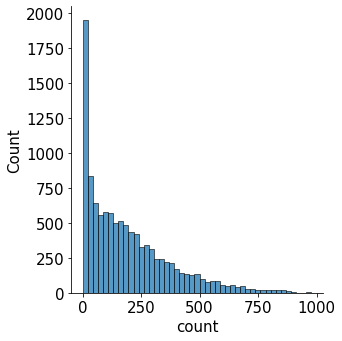

In [440]:
sns.displot(train_data['count'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


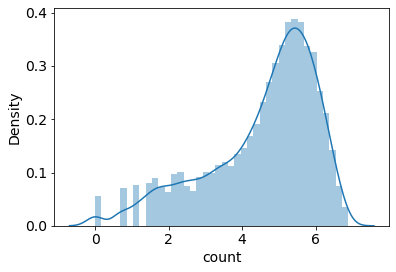

In [492]:
# count를 기준으로 그래프를 그려보니, 정규분포의 형태가 아닌 치우친 형태를 지니므로, 분석 시에는 로그 함수를 활용해 그렸다가, 마지막에 지수 변환해서 활용하는 것이 더 좋음
sns.distplot(np.log(train_data['count']))
# sns.kdeplot(np.log(train_data['count']))


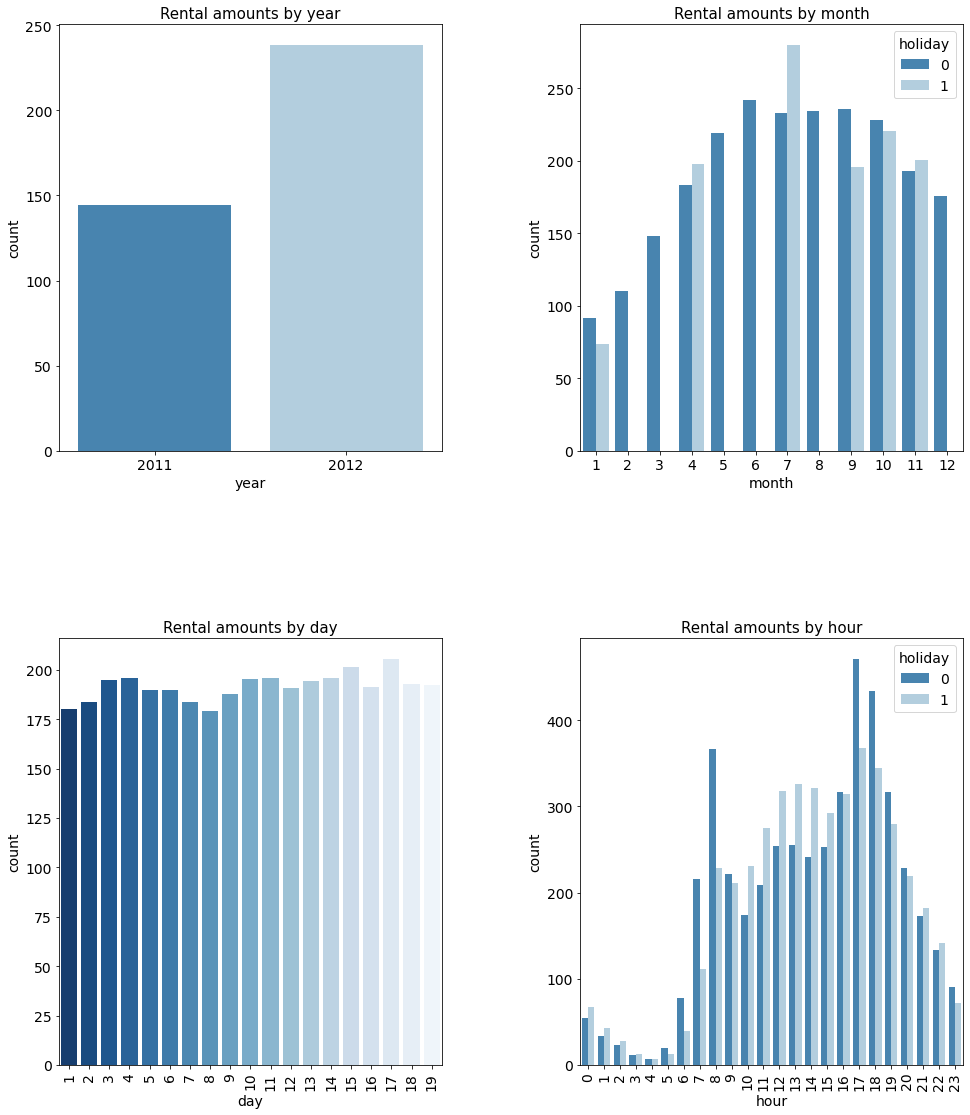

In [498]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=14)       # 폰트 크기 설정
mpl.rc('axes', titlesize=15)  # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=2, ncols=2) # 3행 2열 Figure 생성 
plt.tight_layout()            # 그래프 사이에 여백 확보 
figure.set_size_inches(15, 18) # 전체 Figure 크기를 10x9인치로 설정 

# 스텝 2 : 각 축에 서브플롯 할당
# 각 축에 연도, 월, 일, 시간, 분, 초별 평균 대여 수량 막대 그래프 할당
sns.barplot(x='year', y='count', data=train_data, ax=axes[0, 0], palette="Blues_r", ci = None)
sns.barplot(x='month', y='count', data=train_data, ax=axes[0, 1], palette="Blues_r", hue='holiday', ci = None)
sns.barplot(x='day', y='count', data=train_data, ax=axes[1, 0], palette="Blues_r", ci = None)
sns.barplot(x='hour', y='count', data=train_data, ax=axes[1, 1], palette="Blues_r", hue='holiday', ci = None)

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title='Rental amounts by year')
axes[0, 1].set(title='Rental amounts by month')
axes[1, 0].set(title='Rental amounts by day')
axes[1, 1].set(title='Rental amounts by hour')

# 3-2 : 1행에 위치한 서브플롯들의 x축 라벨 90도 회전
axes[1, 0].tick_params(axis='x', labelrotation=90)
axes[1, 1].tick_params(axis='x', labelrotation=90)


In [493]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


In [494]:
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


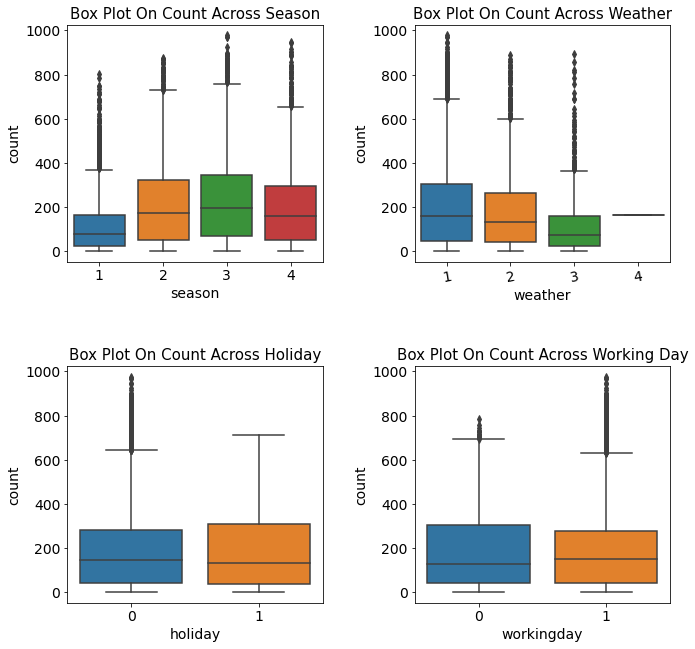

In [443]:
# 스텝 1 : m행 n열 Figure 준비
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(10, 10)

# 스텝 2 : 서브플롯 할당
# 계절, 날씨, 공휴일, 근무일별 대여 수량 박스플롯
sns.boxplot(x='season', y='count', data=train_data, ax=axes[0, 0])
sns.boxplot(x='weather', y='count', data=train_data, ax=axes[0, 1])
sns.boxplot(x='holiday', y='count', data=train_data, ax=axes[1, 0])
sns.boxplot(x='workingday', y='count', data=train_data, ax=axes[1, 1])

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title='Box Plot On Count Across Season')
axes[0, 1].set(title='Box Plot On Count Across Weather')
axes[1, 0].set(title='Box Plot On Count Across Holiday')
axes[1, 1].set(title='Box Plot On Count Across Working Day')

# 3-2 : x축 라벨 겹침 해결
axes[0, 1].tick_params('x', labelrotation=10) # 10도 회전

1. 봄에 가장 대여 수량이 적고 가을에 가장 많음
2. 날씨가 좋을 때 대여 수량이 많고, 날씨가 안 좋을 수록 대여 수량이 적음(폭우 폭설의 경우 거의 없음)
3. 3, 4 그래프를 기준으로 공휴일이 아닌 날(일 하는 날)에 이상치가 가장 많이 존재

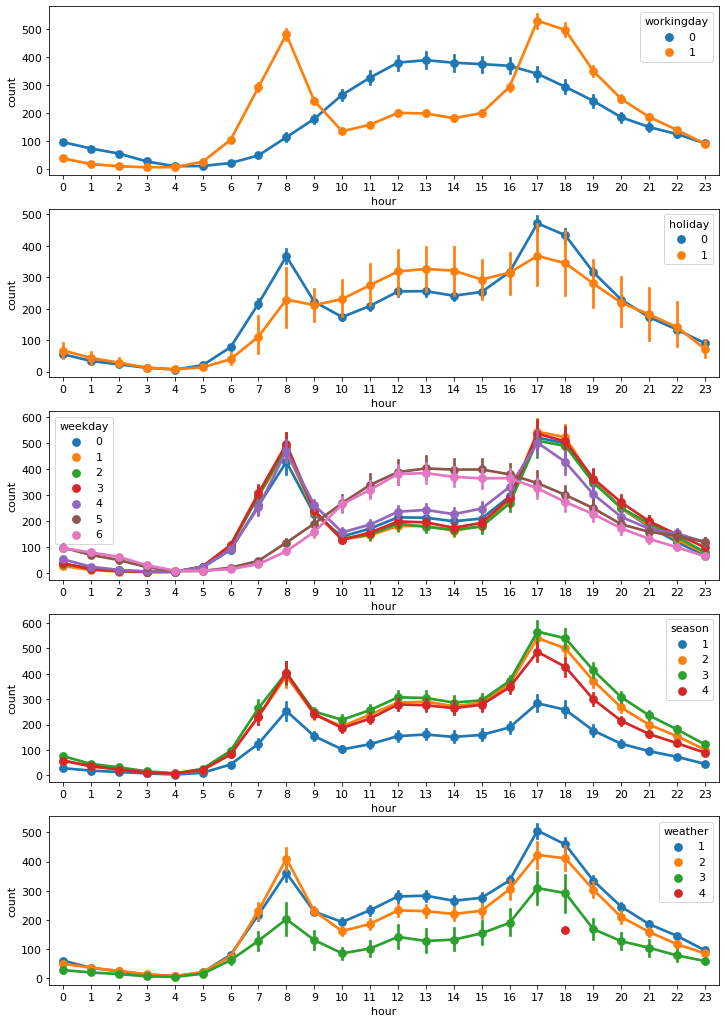

In [444]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=5) # 5행 1열
figure.set_size_inches(12, 18)

# 스텝 2 : 서브플롯 할당
# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트플롯
sns.pointplot(x='hour', y='count', data=train_data, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train_data, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train_data, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train_data, hue='season', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train_data, hue='weather', ax=axes[4]);

## 시간에 따른 대여량 
- 1: 맑음,구름 조금,흐림
- 2: 안개+흐림, 안개+구름, 안개+ 구름이 거의 없음 + 흐림
- 3: 가벼운 눈, 가벼운 비 + 천둥+ 구름, 가벼운 비 + 구름
- 4: 폭우 + 우박 + 천둥 + 안개, 눈 + 안개
- Weather의 4: 폭우 + 우박 + 천둥 + 안개, 눈 + 안개 항목은 없다고 생각해도 될 데이터라, 향후 분석시에는 제거
- 출퇴근 시간이라고 예상되는 8시, 17시, 18시가 가장 대여량이 많음.
- 폭우와 폭설이 내리는 날씨(heavy)는 대여량이 거의 없는 것을 볼 수 있음.

- 1번 그래프 기준 출 퇴근 시간에 가장 대여 수가 많음
- 5번 그래프에서 날씨가 안 좋은 경우에 18시에 한 번 대여 -> 이상치 이므로 제거하는 것이 이상적(weather == 4 제거)


## 1~3월에 상대적으로 대여량이 적은이유는 아래 그래프처럼 날씨가 추워서 그런것으로 생각됨
### * 출처 : https://ko.weatherspark.com/y/20957/%EB%AF%B8%EA%B5%AD-%EC%BB%AC%EB%9F%BC%EB%B9%84%EC%95%84-%ED%8A%B9%EB%B3%84%EA%B5%AC-%EC%9B%8C%EC%8B%B1%ED%84%B4-D.C.%EC%97%90%EC%84%9C-%EB%85%84%EC%A4%91-%ED%8F%89%EA%B7%A0-%EB%82%A0%EC%94%A8
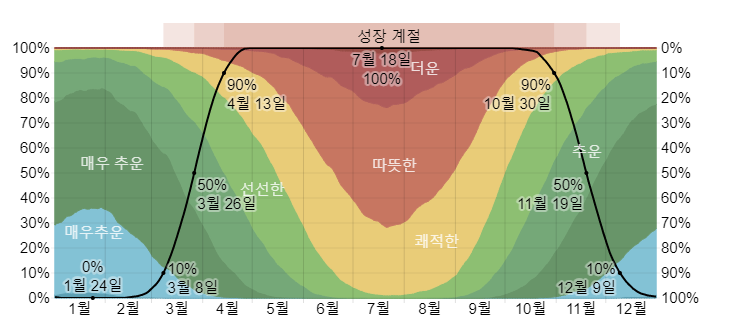

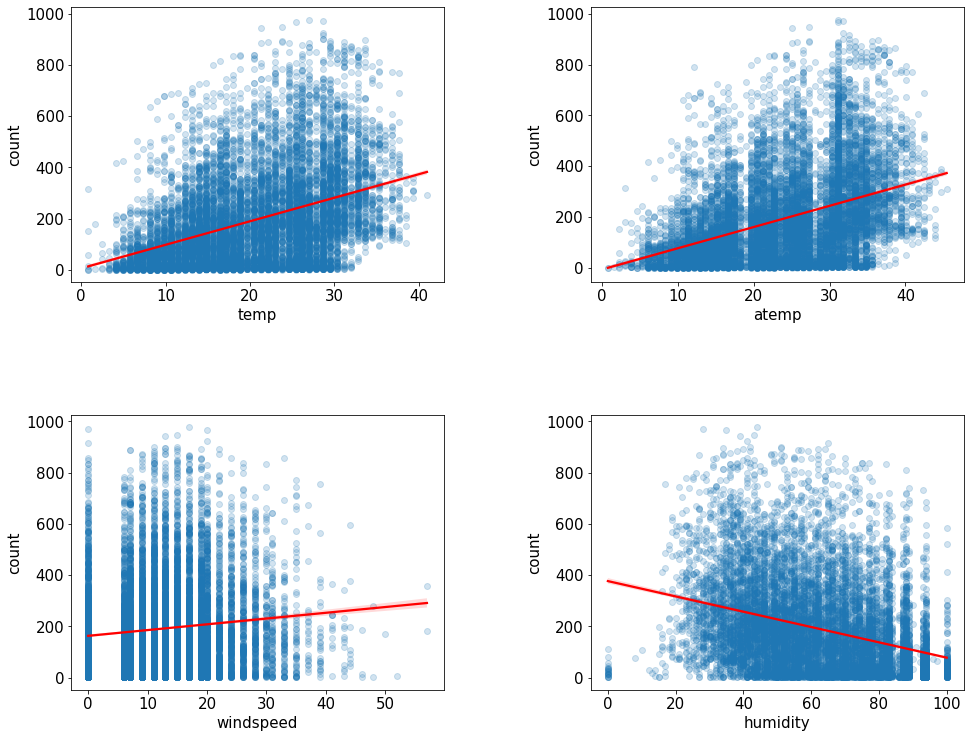

In [485]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(15, 12)

# 스텝 2 : 서브플롯 할당
# 온도, 체감 온도, 풍속, 습도 별 대여 수량 산점도 그래프
sns.regplot(x='temp', y='count', data=train_data, ax=axes[0, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'red'})
sns.regplot(x='atemp', y='count', data=train_data, ax=axes[0, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'red'})
sns.regplot(x='windspeed', y='count', data=train_data, ax=axes[1, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'red'})
sns.regplot(x='humidity', y='count', data=train_data, ax=axes[1, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'red'});

## windspped, humidity의 값이 없는 구간 확인해보기

In [482]:
train_data['windspeed'].value_counts().sort_index()

0.0000     1313
6.0032      871
7.0015     1034
8.9981     1120
11.0014    1057
12.9980    1042
15.0013     961
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
36.9974      22
39.0007      27
40.9973      11
43.0006      12
43.9989       8
46.0022       3
47.9988       2
50.0021       1
51.9987       1
56.9969       2
Name: windspeed, dtype: int64

In [483]:
train_data['humidity'].value_counts().sort_index()

0       22
8        1
10       1
12       1
13       1
      ... 
93     205
94     324
96       1
97       1
100    148
Name: humidity, Length: 89, dtype: int64

In [446]:
train_data.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,-0.004797,0.971524,0.001729,-0.006546,-0.010553
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,0.012021,0.001731,-0.015877,-0.000354,-0.191832
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,-0.002482,-0.003394,0.009829,0.002780,-0.704267
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.012548,0.012144,-0.007890,-0.022740,-0.047692
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.061226,0.257589,0.015551,0.145430,-0.038466
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.058540,0.264173,0.011866,0.140343,-0.040235
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,-0.078606,0.204537,-0.011335,-0.278011,-0.026507
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,-0.015221,-0.150192,0.036157,0.146631,-0.024804
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.145241,0.092722,0.014109,0.302045,0.246959
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,0.264265,0.169451,0.019111,0.380540,-0.084427


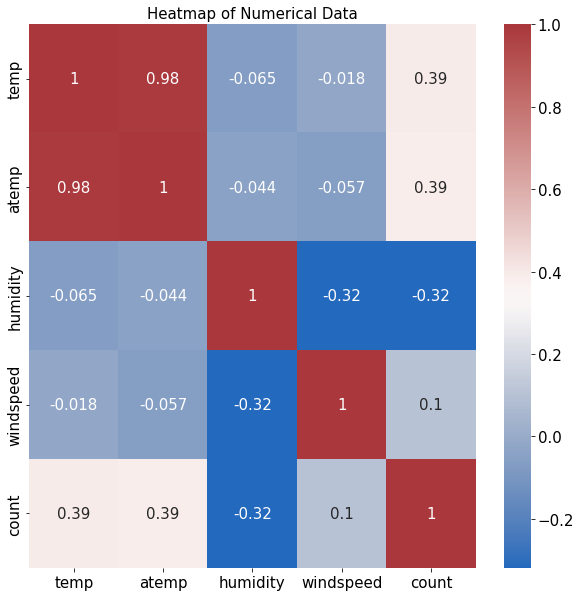

In [447]:
# 피처 간 상관관계 매트릭스
corrMat = train_data[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr() 
fig, ax= plt.subplots() 
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True, cmap='vlag') # 상관관계 히트맵 그리기
ax.set(title='Heatmap of Numerical Data');

- windspeed의 경우 가장 상관관계 수치가 작으므로 도움이 못 될 가능성이 큼(앞에서 확인해본 결과와 같은 의미에 이르므로 삭제)

## 특성 삭제 및 테스트,훈련 데이터 정리

In [448]:
# weather 가 4가 아닌 데이터 추출
train_data = train_data[train_data['weather'] != 4]

In [449]:
all_data = pd.concat([train_data,test_data], ignore_index = True) # 원래 데이터 인덱스 무시하고 붙이기
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,2011.0,1.0,1.0,0.0,5.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,2011.0,1.0,1.0,1.0,5.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,2011.0,1.0,1.0,2.0,5.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,2011.0,1.0,1.0,3.0,5.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,2011.0,1.0,1.0,4.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [450]:
# datetime을 각각의 날짜로 변경
all_data['datetime'] = pd.to_datetime(all_data['datetime'])
all_data['year'] = all_data['datetime'].dt.year
all_data['month'] = all_data['datetime'].dt.month
all_data['hour'] = all_data['datetime'].dt.hour
all_data['weekday'] = all_data['datetime'].dt.dayofweek

In [451]:
drop_features = ['casual', 'registered', 'datetime','windspeed','month','day']

all_data = all_data.drop(drop_features, axis = 1)

In [452]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train_data['count'] # 타깃값

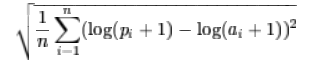
- 이번 문제의 훈련이 제대로 이루어졌는지 확인하는 평가 지표는 RMSLE입니다. 따라서 RMSLE(Root Mean Squared Logarithmic Error)를 계산하는 함수를 만들겠습니다.


In [453]:
def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true) # 타깃
        y_pred = np.exp(y_pred) # 예측
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1)) 
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산하는 식
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

## 모델 훈련(선형 회귀)

In [454]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6493 entries, 10885 to 17377
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   year        6493 non-null   int64  
 8   hour        6493 non-null   int64  
 9   weekday     6493 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 558.0 KB


In [470]:
from sklearn.linear_model import LinearRegression
linear_reg_model = LinearRegression()

In [471]:
log_y = np.log(y) # 훈련 전 타깃값 로그 변환
linear_reg_model.fit(X_train, log_y)

LinearRegression()

In [472]:
preds = linear_reg_model.predict(X_train)

In [473]:
linearreg_preds = linear_reg_model.predict(X_test) # 테스트 데이터로 예측

submission['count'] = np.exp(linearreg_preds)    # 지수변환

In [474]:
# 평가
print(f'선형회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}') 

선형회귀 RMSLE 값 : 1.0205


## 릿지 모델 활용

In [459]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

그리드서치 생성 및 수행

In [460]:
# 하이퍼 파라미터 값 목록
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,   # 릿지 모델
                                      param_grid=ridge_params, # 값 목록
                                      scoring=rmsle_scorer,    # 평가지표
                                      cv=5)                    # 교차검증 분할 수

In [461]:
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [462]:
print('최적 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


In [463]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train) 

# 평가
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}') 

릿지 회귀 RMSLE 값 : 1.0205


## 라쏘 모델

In [464]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()
# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}


In [465]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


## 랜덤 포레스트

In [466]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


In [467]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1127


In [477]:
import lightgbm as lgb
lgb = lgb.LGBMRegressor(num_leaves=2)

In [478]:
log_y = np.log(y)
lgb.fit(X_train, log_y)

LGBMRegressor(num_leaves=2)

In [480]:
# 예측
preds = lgb.predict(X_train)

# 평가
print(f'lightgbm : {rmsle(log_y, preds, True):.4f}')

lightgbm : 0.6735


이정호


이강주


김재희


손덕승
